In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools
from coniii import *

In [2]:
np.random.seed(0)

In [3]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [4]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [5]:
def generate_seqs(n_var,n_seq,n_sample=30,g=1.0):
    n_ops = n_var+int(n_var*(n_var-1)/2.0)
    #w_true = g*(np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
    w_true = np.random.normal(0.,g/np.sqrt(n_var),size=n_ops)
    
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    #n_ops = ops.shape[1]

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [6]:
def hopfield_model(s):
    ops = operators(s)
    w = np.mean(ops,axis=0)
    #print('hopfield error ',nplin.norm(w-w_true))
    return w

In [7]:
def MLE(s,s_all,max_iter=100,alpha=5e-2,cov=False):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])
    ops_obs = np.mean(ops,axis=0)
    ops_model = operators(s_all)

    n_ops = ops.shape[1]
    
    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        #if iterate%10 == 0: 
            #print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
            #MSE = ((w-w_true)**2).mean()
            #print(iterate,MSE)
            
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))

    #print('final',iterate,MSE)

    return w

In [8]:
def eps_machine(s,eps_scale=0.1,max_iter=100,alpha=0.1,eps_type='random'):
    MSE = np.zeros(max_iter)
    #KL = np.zeros(max_iter)
    E_av = np.zeros(max_iter)
    
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    
    w_iter = np.zeros((max_iter,n_ops))
    for i in range(max_iter):         
        if eps_type == 'random':
            eps_scale = np.random.rand()/np.max([1.,np.max(np.abs(w))])            
        #if eps_scale == 'modified':    
        #    eps_scale /= np.max([1.,np.max(np.abs(w))])
        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        E_exp = (probs_w*energies_w).sum()
        E_av[i] = energies_w.mean()
        
        #KL[i] = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale))) + n_var*np.log(2.)        
        #MSE[i] = ((w-w_true)**2).mean()
        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))           
        #w_iter[i,:] = w
        
    return -E_av,w

In [9]:
max_iter = 100

n_var,n_seq = 40,6000
g = 0.5

w_true,seqs = generate_seqs(n_var,n_seq,g=g)
n_ops = n_var+int(n_var*(n_var-1)/2.0)

n_method = 5
w = np.zeros((n_method,n_ops))
mse = np.zeros(n_method)

In [10]:
## Hopfield:
w_hf = hopfield_model(seqs)

w[0,:] = w_hf
mse[0] = ((w_hf-w_true)**2).mean()
print('HF:',mse[0])

HF: 0.0023402540711492384


In [11]:
## MLE:
#s_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_var)))
#print('all configs size:',s_all.shape)
#w_mle = MLE(seqs,s_all,cov=False)

#w[1,:] = w_mle
#mse[1] = ((w_mle-w_true)**2).mean()
#print('MLE:',mse[1])

In [12]:
## pseudo likelihood estimation
np.random.seed(13)
# Define common functions
calc_e,calc_observables,mchApproximation = define_ising_helper_functions()    
get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n_var)

solver = Pseudo(n_var,calc_observables=calc_observables,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r)

w_pl = solver.solve(seqs,np.zeros(n_ops))

w[2,:] = w_pl
mse[2] = ((w_pl-w_true)**2).mean()
print('PL:',mse[2])

/home/tai/anaconda3/lib/python3.7/site-packages/coniii/utils.py:696: UserWarning: DEPRECATION WARNING: now renamed to define_pseudo_ising_helper_functions
  warn("DEPRECATION WARNING: now renamed to define_pseudo_ising_helper_functions")


PL: 0.0006271313164034865


In [13]:
## random eps
E_av,w_random = eps_machine(seqs,eps_scale=0.1,max_iter=max_iter,eps_type='random')

w[3,:] = w_random
mse[3] = ((w_random-w_true)**2).mean()
print('random eps:',mse[3])

random eps: 0.0011006371439266367


optimal eps: 62 0.6511111111111111
opt epsilon: 0.0006218803542032175


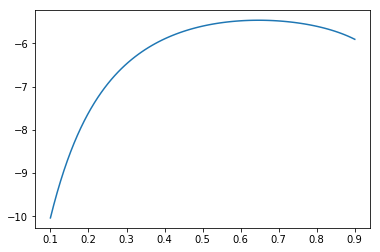

In [14]:
## optimal eps
eps_list = np.linspace(0.1,0.9,91)
n_eps = len(eps_list)

E_av = np.zeros((n_eps,max_iter))
w_eps = np.zeros((n_eps,n_ops))
for i,eps in enumerate(eps_list):    
    E_av[i,:],w_eps[i,:] = eps_machine(seqs,eps_scale=eps,max_iter=max_iter,eps_type='optimal')
    #print(eps,E_av[i,-1])

ieps = np.argmax(E_av[:,-1])
print('optimal eps:',ieps,eps_list[ieps])
w_opt = w_eps[ieps]

w[4,:] = w_eps[ieps]
mse[4] = ((w_eps[ieps]-w_true)**2).mean()
print('opt epsilon:',mse[4])

plt.plot(eps_list,E_av[:,-1])

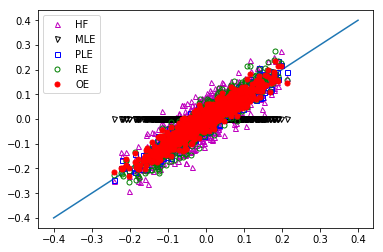

In [15]:
plt.plot([-0.4,0.4],[-0.4,0.4])
plt.plot(w_true,w[0],'m^',marker='^',mfc='none',markersize=5,label='HF')
plt.plot(w_true,w[1],'kv',marker='v',mfc='none',markersize=5,label='MLE')
plt.plot(w_true,w[2],'bs',marker='s',mfc='none',markersize=5,label='PLE')
plt.plot(w_true,w[3],'go',marker='o',mfc='none',markersize=5,label='RE')
plt.plot(w_true,w[4],'ro',marker='o',markersize=5,label='OE')

plt.legend()

In [16]:
print(mse)
w_all = np.vstack((w_true[np.newaxis,:],w))
np.savetxt('w_%s_%s_%s.dat'%(n_var,g,n_seq),w_all,fmt='%f')
np.savetxt('mse_%s_%s_%s.dat'%(n_var,g,n_seq),mse,fmt='%f')

[0.00234025 0.         0.00062713 0.00110064 0.00062188]
